In [1]:
import gc
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import optuna

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import catboost as cb

import pickle

In [2]:
class CONFIG:
    SEED = 67
    TARGET = 'diagnosed_diabetes'
    TEST_SIZE = 0.2

    TRAIN_PATH = '/kaggle/input/playground-series-s5e12/train.csv'
    TEST_PATH = '/kaggle/input/playground-series-s5e12/test.csv'

    FOLDS = 10

cfg = CONFIG()

In [3]:
def print_design(data: None| str = None):
    print('=' * 25)
    if data:
        print(data)
        print('=' * 25)
        print()

def load_pickle(path):
    try:
        with open(path, 'rb') as f:
            data =  pickle.load(f)
        return data
    except:
        print('Please provide a valid path or filename.')


def write_pickle(path, data):
    try:
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    except:
        print('Please provide a valid path or filename.')

In [4]:
def import_data(cfg: CONFIG = cfg, sep_ids=True):
    print_design("1. IMPORTING DATASET")
    train = pd.read_csv(cfg.TRAIN_PATH)
    test = pd.read_csv(cfg.TEST_PATH)
    print('\n- Successfully imported the datasets\n')

    test_ids = None
    if sep_ids:
        print('--- Separating and Removing Ids ---\n')
        train = train.drop('id', axis=1)
        test_ids = test.id
        test = test.drop('id', axis=1)
        print('- Successfully done!')
        return train, test, test_ids

    print_design()
        
    return train, test

In [5]:
def object_to_category(train, test, return_cat_cols=True):
    print_design('2. Handling CATS')

    cat_cols = train.select_dtypes(['object']).columns

    for cat in cat_cols:
        print(f'- Transforming {cat}')
        train[cat] = train[cat].astype('category')
        test[cat] = test[cat].astype('category')

    print('\n- Successfully Completed')
    print_design()
    if return_cat_cols:
        return train, test, cat_cols
    return train, test

In [6]:
def split_data(train, train_test=False):
    print_design("3. SPLIT DATA")

    X = train.drop([cfg.TARGET], axis=1)
    y = train[cfg.TARGET]

    print('\n- Successfully splitted\n')
    print_design()
    
    if train_test:
        return train_test_split(X, y, test_size=cfg.TEST_SIZE, random_state=cfg.SEED)

    return X, y

In [7]:
def submit_test(test_ids, test_preds):
    print_design("5. SUBMITTING TEST")
    output = pd.DataFrame({
        'id': test_ids,
        cfg.TARGET: test_preds
    })

    output.to_csv('submission.csv', index=False)
    return output.head()

In [8]:
def plot_train_val(train, val, title):
    assert len(train) == len(val), "Train and val lenght should be equal"

    plt.figure(figsize=(8, 4.5))

    plt.plot(train, label="Train Acc")
    plt.plot(val, label="Val Acc")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()

    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [9]:
def train_model(X, y, test, model, cat_cols, plots=True):
    name = model['name']
    print_design(f'4. TRAINING MODEL {name}')

    skf = StratifiedKFold(n_splits=cfg.FOLDS, shuffle=True, random_state=cfg.SEED)

    oof_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(test.shape[0])
    train_errors = []
    val_errors = []
    cv_folds = {}

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        print(f'\n-- Fold {fold} --\n')

        X_train = X.iloc[tr]
        y_train = y[tr]
        X_val = X.iloc[va]
        y_val = y[va]

        if name == 'LIGHTGBM':
            lgb_dataset = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
            tr_model = lgb.train(train_set=lgb_dataset, params=model['params'])
        elif name == 'CATBOOST':
            train_dataset = cb.Pool(X_train, y_train, cat_features=cat_cols)
            val_dataset = cb.Pool(X_val, y_val, cat_features=cat_cols)
            tr_model = cb.CatBoostClassifier(**models[1]['params'])
            tr_model.fit(train_dataset, eval_set=[val_dataset], early_stopping_rounds=200, use_best_model=True)

        train_preds = tr_model.predict(X_train)
        train_error = roc_auc_score(y_train, train_preds)
        
        val_error = roc_auc_score(y_val, tr_model.predict(X_val))

        train_errors.append(train_error)
        val_errors.append(val_error)
        oof_preds[tr] = train_preds

        test_preds += tr_model.predict(test)
        
        cv_folds[fold] = tr_model
        
        print(f'- Train Error {train_error:.6f}')
        print(f'- Val Error {val_error:.6f}\n')

    test_preds = test_preds/(skf.get_n_splits())

    print_design('MEAN OF ERRORS')
    print(f'- Train Error {np.mean(train_error):.6f}')
    print(f'- Val Error {np.mean(val_error):.6f}\n')

    data = {
        'name': name,
        'cv_models': cv_folds,
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'train_error': train_error,
        'val_error': val_error
    }

    write_pickle(f'{name}_{np.mean(val_error)}_data.pkl', data)
    
    del tr_model, skf, X, y, X_train, X_val, y_train, y_val, train_preds
    gc.collect()

    if plots:
        print(f'\n-- Seeing some plots --\n')
    
        plot_train_val(train_errors, val_errors, name)
    
        print(" " * 3)
    
    return oof_preds, test_preds

In [10]:
models = {
    0: {
        "name": "LIGHTGBM",
        "params": {
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.09990567366337798,
                'num_leaves':  203,      
                'n_estimators': 5, 
                'max_depth': 12,
                'min_child_samples': 184,
                'colsample_bytree': 0.8,
                'lambda_l1': 0.3982350299843493, 
                'lambda_l2': 4.412853547060553e-05,
                'feature_fraction': 0.4099195570257677, 
                'bagging_fraction': 0.9994596878397021, 
                'bagging_freq': 1, 
                'subsample': 0.7,
                'random_state': cfg.SEED,
                'n_jobs': -1,
                'verbosity': -1   
        }
    },
    1: {
        'name': 'CATBOOST',
        'params': {
            'loss_function': 'Logloss',
            'iterations': 6000,
            'learning_rate': 0.05,
            'depth': 6,
            'eval_metric': 'AUC',
            'random_seed': cfg.SEED,
            'verbose': 0,
            'allow_writing_files': False,
            'task_type': 'CPU',
            'l2_leaf_reg': 3,
            'min_data_in_leaf': 20,
            'subsample': 0.8,
            'rsm': 0.8,
            'random_strength': 1,
            'grow_policy': 'SymmetricTree',
            'bootstrap_type': 'Bernoulli',
            'leaf_estimation_iterations': 5
        }
    }
}

In [11]:
train, test, test_ids = import_data()

1. IMPORTING DATASET


- Successfully imported the datasets

--- Separating and Removing Ids ---

- Successfully done!


In [12]:
train, test, cat_cols = object_to_category(train, test)

2. Handling CATS

- Transforming gender
- Transforming ethnicity
- Transforming education_level
- Transforming income_level
- Transforming smoking_status
- Transforming employment_status

- Successfully Completed


In [13]:
X, y = split_data(train)

3. SPLIT DATA


- Successfully splitted



4. TRAINING MODEL CATBOOST


-- Fold 1 --

- Train Error 0.649200
- Val Error 0.630884


-- Fold 2 --

- Train Error 0.650599
- Val Error 0.634027


-- Fold 3 --

- Train Error 0.645761
- Val Error 0.632191


-- Fold 4 --

- Train Error 0.649205
- Val Error 0.632944


-- Fold 5 --

- Train Error 0.648826
- Val Error 0.635424


-- Fold 6 --

- Train Error 0.649907
- Val Error 0.634730


-- Fold 7 --

- Train Error 0.653701
- Val Error 0.630879


-- Fold 8 --

- Train Error 0.647444
- Val Error 0.633291


-- Fold 9 --

- Train Error 0.654007
- Val Error 0.636912


-- Fold 10 --

- Train Error 0.655844
- Val Error 0.632949

MEAN OF ERRORS

- Train Error 0.655844
- Val Error 0.632949


-- Seeing some plots --



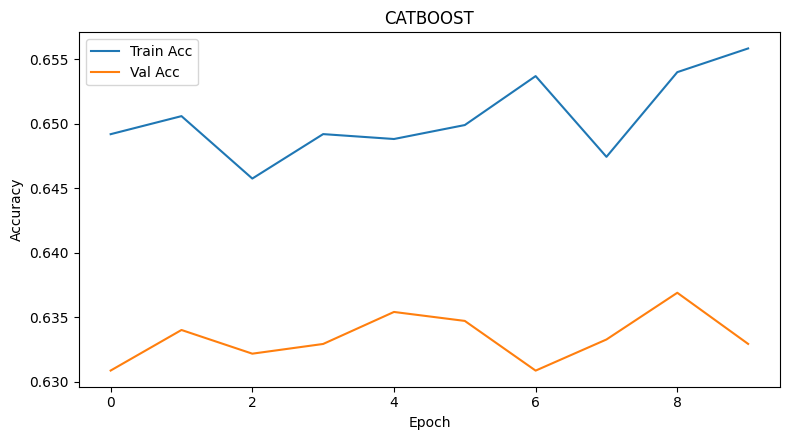

In [14]:
oof_preds, test_preds = train_model(X, y, test, models[1], list(cat_cols))

In [15]:
submit_test(test_ids, test_preds)

5. SUBMITTING TEST



,id,diagnosed_diabetes
0,700000,0.2
1,700001,1.0
2,700002,1.0
3,700003,0.0
4,700004,1.0
